<a href="https://colab.research.google.com/github/almasrifi-rami/movements-ml/blob/main/har_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/project/src')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

import utils

In [3]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

In [4]:
X, y = utils.get_data()

In [5]:
num_classes = len(np.unique(y))

le = LabelEncoder()
y = le.fit_transform(y)

# idx = np.random.permutation(len(X_train))
# X_train = X_train[idx]
# y_train = y_train[idx]

idx_train, idx_, y_train, y_ = train_test_split(
    np.arange(X.shape[0]), y,
    test_size=0.4, random_state=42, shuffle=True, stratify=y)

idx_valid, idx_test, y_valid, y_test = train_test_split(
    idx_, y_,
    test_size=0.5, random_state=42, shuffle=True)

X_train, X_valid, X_test = X[idx_train], X[idx_valid], X[idx_test]

In [6]:
del X, y

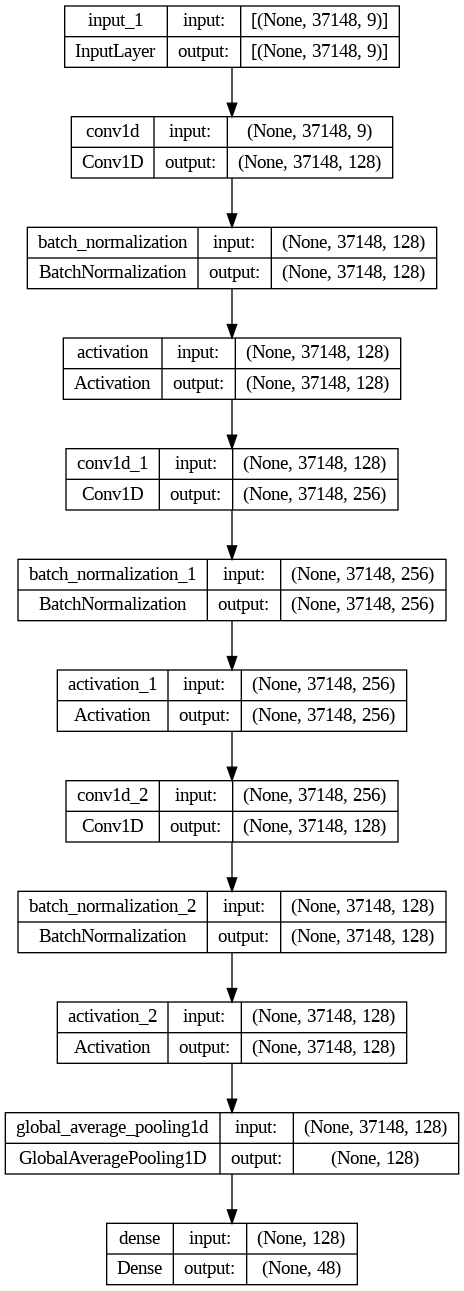

In [7]:
def make_model(input_shape, nb_classes):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model


model = make_model(input_shape=X_train.shape[1:], nb_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)


In [8]:
epochs = 20
batch_size = 16

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid),
    verbose=1,
)

Epoch 1/20
447/447 [==============================] - 62s 108ms/step - loss: 1.8260 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.5680 - val_sparse_categorical_accuracy: 0.5384 - lr: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


447/447 [==============================] - 37s 83ms/step - loss: 1.4891 - sparse_categorical_accuracy: 0.5580 - val_loss: 1.3878 - val_sparse_categorical_accuracy: 0.5674 - lr: 0.0010
Epoch 3/20
447/447 [==============================] - 36s 81ms/step - loss: 1.3795 - sparse_categorical_accuracy: 0.5813 - val_loss: 1.4451 - val_sparse_categorical_accuracy: 0.5854 - lr: 0.0010
Epoch 4/20
447/447 [==============================] - 37s 83ms/step - loss: 1.2941 - sparse_categorical_accuracy: 0.6014 - val_loss: 1.3219 - val_sparse_categorical_accuracy: 0.5917 - lr: 0.0010
Epoch 5/20
447/447 [==============================] - 37s 83ms/step - loss: 1.2156 - sparse_categorical_accuracy: 0.6182 - val_loss: 1.2521 - val_sparse_categorical_accuracy: 0.6089 - lr: 0.0010
Epoch 6/20
447/447 [==============================] - 37s 83ms/step - loss: 1.1643 - sparse_categorical_accuracy: 0.6344 - val_loss: 1.2137 - val_sparse_categorical_accuracy: 0.6190 - lr: 0.0010
Epoch 7/20
447/447 [================

In [9]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

75/75 [==============================] - 6s 40ms/step - loss: 1.0251 - sparse_categorical_accuracy: 0.6602
Test accuracy 0.6602349281311035
Test loss 1.0251083374023438


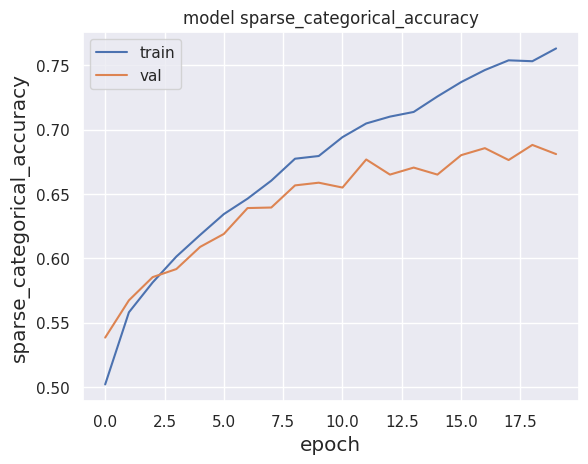

In [10]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

75/75 [==============================] - 3s 39ms/step


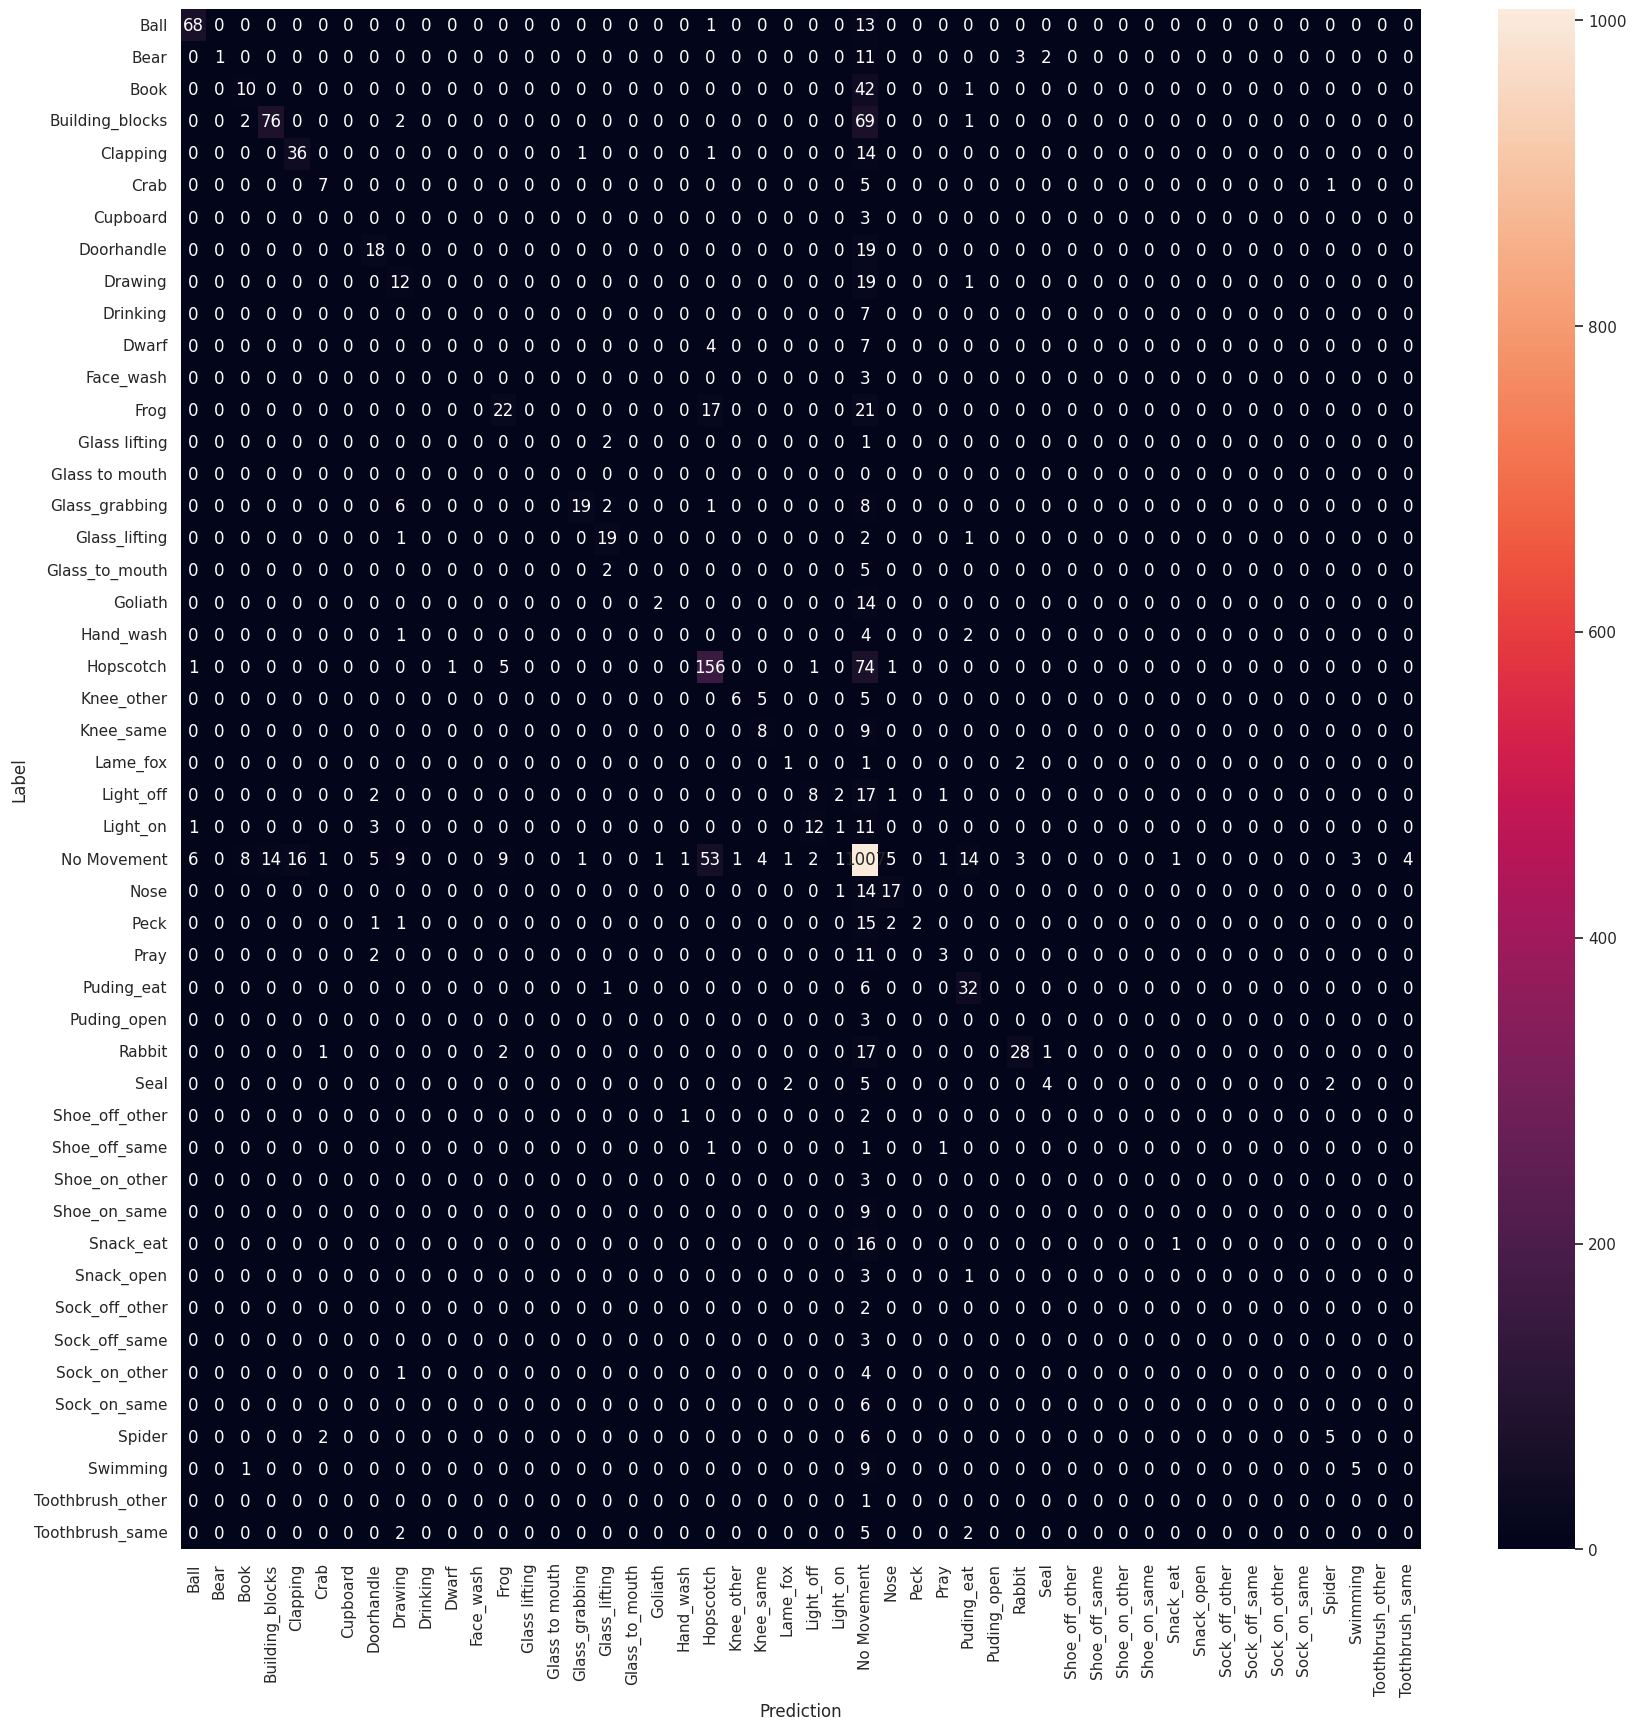

In [11]:
y_pred = model.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)

confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_mtx,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()